# Data Science at Scale: Capstone Project

#### Author: Takayuki Kaisen 
#### contact: ksn0215@gmail.com
#### Date: May 2018

# 1. Preparation

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import folium
import re

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
from IPython.display import HTML

In [4]:
import math

In [5]:
import pygeohash as pgh

## 1.1 Load Data

You can get data from here: https://github.com/uwescience/datasci_course_materials/tree/master/capstone/blight/data  

Please create a directory named `data` and put data into the directory!  

NOTE: Data is large, therefore you need to use `$ git lfs fetch` if you want to use git command

In [6]:
det311_data = pd.read_csv('data/detroit-311.csv')

In [7]:
blight_data = pd.read_csv('data/detroit-blight-violations.csv',low_memory=False)

In [8]:
permits_data = pd.read_csv('data/detroit-demolition-permits.tsv',low_memory=False,delimiter='\t')

In [9]:
crime_data = pd.read_csv('data/detroit-crime.csv',low_memory=False)

In [10]:
crime_data = crime_data[~np.isnan(crime_data['LAT'])] # Remove NAN
crime_data = crime_data[~np.isnan(crime_data['LON'])] # Remove NAN

## 1.2 Data Wrangling

#### Defenition of boundaries

In [11]:
north_bound = 42.443509 # East 8 Mile Road
south_bound = 42.255240 # Boynton
east_bound  = -82.910255  # Grosse Pointe Farmes
west_bound  = -83.289626  # Southfield

#### Remove points out of Detroit

In [12]:
crime_data = crime_data[(crime_data.LAT >= south_bound) & (crime_data.LAT <= north_bound) & (crime_data.LON <= east_bound) & (crime_data.LON >= west_bound)]

In [13]:
#crime_data.index

In [14]:
#pgh.encode(42.3678,-83.1221)

#### Creating 'building_if' using encoding

In [15]:
crime_data['building_id'] = [pgh.encode(crime_data['LAT'][i],crime_data['LON'][i]) for i in crime_data.index]

In [16]:
len(crime_data['building_id'].unique()) # The number of buildings

99938

In [17]:
crime_data.head()

,ROWNUM,CASEID,INCINO,CATEGORY,OFFENSEDESCRIPTION,STATEOFFENSEFILECLASS,INCIDENTDATE,HOUR,SCA,PRECINCT,COUNCIL,NEIGHBORHOOD,CENSUSTRACT,ADDRESS,LON,LAT,LOCATION,building_id
0,53256,1953933,1506030028.1,ASSAULT,ASSAULT AND BATTERY/SIMPLE ASSAULT,13001.0,06/03/2015 12:00:00 AM,2,1007.0,10.0,City Council District 5,PETOSKEY-OTSEGO,5334.0,09100 PETOSKEY,-83.1221,42.3678,"PETOSKEY\n09100\n(42.3676, -83.1219)",dpsch8b66dmg
1,17631,1917717,1503010158.1,LARCENY,LARCENY - PARTS AND ACCESSORIES FROM VEHICLE,23006.0,03/01/2015 12:00:00 AM,9,608.0,6.0,City Council District 7,GRANDALE,5452.0,00 PLYMOUTH AND MANSFIELD,-83.2035,42.3724,"00 PLYMOUTH AND MANSFIELD\n(42.3725, -83.2033)",dpsc49tj1gve
2,11207,1910955,1502080223.1,STOLEN VEHICLE,VEHICLE THEFT,24001.0,02/08/2015 12:00:00 AM,18,1105.0,11.0,City Council District 3,OUTER DRIVE VAN DYKE,5051.0,00 E 7 MILE VAN DYKE,-83.0241,42.4338,"00 E 7 MILE VAN DYKE\n(42.4339, -83.0241)",dpscqszdy38h
3,116589,2018186,1511090188.1,WEAPONS OFFENSES,WEAPONS OFFENSE (OTHER),52003.0,11/09/2015 12:00:00 AM,12,210.0,2.0,City Council District 6,TIREMAN,NaN,06600 BARTON,-83.1381,42.3496,"BARTON\n06600\n(42.3494, -83.1379)",dpsbujs8mcek
4,85790,1986862,1508239803.1,LARCENY,LARCENY - PARTS AND ACCESSORIES FROM VEHICLE,23006.0,08/14/2015 12:00:00 AM,7,309.0,3.0,City Council District 6,WEST CANFIELD,5204.0,00900 W WILLIS,-83.0692,42.3481,"W WILLIS\n00900\n(42.3481, -83.0693)",dpsbvtnze650


In [18]:
permits_data['BLD_PERMIT_TYPE'].unique()

array(['Dismantle', 'DISM'], dtype=object)

# 2.Visualization

## 2.1. Create heatmap for crimes

In [19]:
df = pd.DataFrame()
df = df.append(crime_data['LAT'])
df = df.append(crime_data['LON'])
df = df.T

In [20]:
df.head()

,LAT,LON
0,42.3678,-83.1221
1,42.3724,-83.2035
2,42.4338,-83.0241
3,42.3496,-83.1381
4,42.3481,-83.0692


#### Clustering buuildings

In [21]:
df = df.reset_index(drop=True)

In [22]:
df['LAT'] = round(df['LAT'],3)
df['LON'] = round(df['LON'],3)

In [23]:
df.head()

,LAT,LON
0,42.368,-83.122
1,42.372,-83.204
2,42.434,-83.024
3,42.350,-83.138
4,42.348,-83.069


#### Making a map

In [24]:
from folium.plugins import HeatMap
#map_detroit = folium.Map(location=(42.20,-83.01))
map_detroit = folium.Map(location=(42.40,-83.01))


data = []
for i in range(len(df)):
  data.append((df['LAT'][i],df['LON'][i]))
HeatMap(data,radius=9).add_to(map_detroit)
map_detroit.save('crimes.html')

In [25]:
HTML(r'<iframe width="800" height="500" frameborder="0" allowfullscreen src="./crimes.html"></iframe>')

## 2.2 Create heatmap for 311 calls

In [26]:
det311_data['lat'] = round(det311_data['lat'],3)
det311_data['lng'] = round(det311_data['lng'],3)

In [27]:
det311_data.index

RangeIndex(start=0, stop=19680, step=1)

In [28]:
det311_data['building_id'] = [pgh.encode(det311_data['lat'][i],det311_data['lng'][i]) for i in det311_data.index]

In [29]:
det311_data.head()

,ticket_id,city,issue_type,ticket_status,issue_description,rating,ticket_closed_date_time,acknowledged_at,ticket_created_date_time,ticket_last_updated_date_time,address,lat,lng,location,image,building_id
0,1516722,City of Detroit,Clogged Drain,Acknowledged,"Two drains one on each side of street, street ...",3,NaN,03/06/2015 10:03:38 PM,03/06/2015 09:57:52 PM,04/12/2015 01:01:10 AM,"13120-13130 Ilene Street Detroit, MI 48238, USA",42.384,-83.161,"(42.3839977668, -83.1610385642)",NaN,dpsc5eu08q20
1,1525361,City of Detroit,Clogged Drain,Acknowledged,standing water on lumplin,2,NaN,03/11/2015 04:23:11 PM,03/11/2015 04:14:29 PM,04/07/2015 02:04:44 PM,"1485 E. Outer Drive Detroit, Michigan",42.440,-83.081,"(42.4404708, -83.080919)",NaN,dpscmmyqbmkm
2,1525218,City of Detroit,Clogged Drain,Closed,CITZEN CALLED TO REPORT CLOGGED DRAINS,2,08/15/2015 12:03:43 AM,03/11/2015 03:39:05 PM,03/11/2015 03:26:20 PM,08/15/2015 12:03:44 AM,"15460 Eastburn Detroit, Michigan",42.445,-82.962,"(42.445244, -82.962038)",NaN,dpt12nuuj33p
3,1525214,City of Detroit,Clogged Drain,Acknowledged,Citizen called DWSD to report clogged drain,3,NaN,03/11/2015 03:35:02 PM,03/11/2015 03:22:42 PM,06/07/2015 10:07:48 PM,"17541 Mendota St Detroit, Michigan",42.421,-83.166,"(42.421043, -83.166194)",NaN,dpsc7d825xx9
4,1525142,City of Detroit,Clogged Drain,Acknowledged,@ THE CORNER OF GRIGGS & MARGARETA,2,NaN,03/11/2015 03:04:59 PM,03/11/2015 02:53:23 PM,03/11/2015 03:04:59 PM,"Griggs Detroit, Michigan",42.402,-83.163,"(42.4020334, -83.1628741)",NaN,dpsc5x4999sw


#### Making a map

In [30]:
#map_detroit_311 = folium.Map(location=(42.20,-83.01))
map_detroit_311 = folium.Map(location=(42.40,-83.01))

data = []
for i in range(len(det311_data)):
  data.append((det311_data['lat'][i],det311_data['lng'][i]))
HeatMap(data,radius=9).add_to(map_detroit_311)
map_detroit_311.save('det311.html')

df_311 = pd.DataFrame(data)#
#df_311_points = df_311.as_matrix()

In [31]:
HTML(r'<iframe width="800" height="500" frameborder="0" allowfullscreen src="./det311.html"></iframe>')

## 2.3. Making heatmap for blight violations

Note: The City has ordinances that address how property owners must maintain the exterior of their property.
A blight violation is issued when an owner fails to follow these ordinances.

(Reference) https://www.porthuron.org/content.aspx?Pageid=207

In [32]:
blight_data.index

RangeIndex(start=0, stop=307804, step=1)

In [33]:
blight_data["ViolationAddress"][0]

'2566 GRAND BLVD\nDetroit, MI\n(42.36318237000006, -83.09167672099994)'

In [34]:
blight_data['building_id'] = float(0)

In [35]:
blight_data.head()

,TicketID,TicketNumber,AgencyName,ViolName,ViolationStreetNumber,ViolationStreetName,MailingStreetNumber,MailingStreetName,MailingCity,MailingState,...,LateFee,StateFee,CleanUpCost,JudgmentAmt,PaymentStatus,Void,ViolationCategory,ViolationAddress,MailingAddress,building_id
0,26288,05000001DAH,Department of Public Works,"Group, LLC, Grand Holding",2566,GRAND BLVD,743,"Beaubien, Ste. 201",Detroit,MI,...,$150.00,$10.00,$0.00,$1680.00,PAID IN FULL,0.0,0,"2566 GRAND BLVD\nDetroit, MI\n(42.363182370000...","743 Beaubien\nDetroit, MI 48226\n(42.333730630...",0.0
1,19800,05000025DAH,Department of Public Works,"JACKSON, RAECHELLE",19014,ASHTON,20501,HEYDEN,DETROIT,MI,...,$10.00,$10.00,$0.00,$140.00,NO PAYMENT APPLIED,0.0,0,"19014 ASHTON\nDetroit, MI\n(42.429390762000025...","20501 HEYDEN\nDETROIT, MI 48219\n(42.442177633...",0.0
2,19804,05000026DAH,Department of Public Works,"TALTON, CAROL ANN",18735,STAHELIN,18735,STAHELI N,DETROIT,MI,...,$10.00,$10.00,$0.00,$140.00,PAID IN FULL,0.0,0,"18735 STAHELIN\nDetroit, MI\n(42.4287074590000...","18735 STAHELI N\nDETROIT, MI 48219\n(42.428707...",0.0
3,20208,05000027DAH,Department of Public Works,"BONNER, DARRYL E.",20125,MONICA,25335,PEEKSKILL,SOUTHFIELD,MI,...,$10.00,$10.00,$0.00,$140.00,NO PAYMENT APPLIED,0.0,0,"20125 MONICA\nDetroit, MI\n(42.44169828400004,...","25335 PEEKSKILL\nSOUTHFIELD, MI 48043\n(42.475...",0.0
4,20211,05000028DAH,Department of Public Works,"GREGORY, JAMES LEE",17397,PRAIRIE,17397,PRAIRIE,DETROIT,MI,...,$10.00,$10.00,$0.00,$140.00,PAID IN FULL,0.0,0,"17397 PRAIRIE\nDetroit, MI\n(42.42031769500005...","17397 PRAIRIE\nDETROIT, MI 48221\n(42.42031769...",0.0


#### Making a map

In [36]:
#map_blight = folium.Map(location=(42.20,-83.01))
map_blight = folium.Map(location=(42.40,-83.01))
data = []
for i in range(len(blight_data)):
    a = re.search('\(.+?,',blight_data["ViolationAddress"][i])
    #lat = float(a.group().strip(",").strip("("))
    lat = round(float(a.group().strip(",").strip("(")),3)
    b = re.search(',.+?\)',blight_data["ViolationAddress"][i])
    #lon = float(b.group().replace(" ","").strip(",").strip(")"))
    lon = round(float(b.group().replace(" ","").strip(",").strip(")")),3)
    data.append([lat,lon])
    # blight_data['building_id'][i] = pgh.encode(lat,lon)
HeatMap(data,radius=9).add_to(map_blight)
map_blight.save('blight.html')

df_blight = pd.DataFrame(data)
#df_blight_points = df_blight.as_matrix()

In [37]:
blight_data['building_id'] = [pgh.encode(data[i][0],data[i][1]) for i in blight_data.index]

In [38]:
blight_data.head()

,TicketID,TicketNumber,AgencyName,ViolName,ViolationStreetNumber,ViolationStreetName,MailingStreetNumber,MailingStreetName,MailingCity,MailingState,...,LateFee,StateFee,CleanUpCost,JudgmentAmt,PaymentStatus,Void,ViolationCategory,ViolationAddress,MailingAddress,building_id
0,26288,05000001DAH,Department of Public Works,"Group, LLC, Grand Holding",2566,GRAND BLVD,743,"Beaubien, Ste. 201",Detroit,MI,...,$150.00,$10.00,$0.00,$1680.00,PAID IN FULL,0.0,0,"2566 GRAND BLVD\nDetroit, MI\n(42.363182370000...","743 Beaubien\nDetroit, MI 48226\n(42.333730630...",dpsbvpyq25d4
1,19800,05000025DAH,Department of Public Works,"JACKSON, RAECHELLE",19014,ASHTON,20501,HEYDEN,DETROIT,MI,...,$10.00,$10.00,$0.00,$140.00,NO PAYMENT APPLIED,0.0,0,"19014 ASHTON\nDetroit, MI\n(42.429390762000025...","20501 HEYDEN\nDETROIT, MI 48219\n(42.442177633...",dpsc67cnc6y7
2,19804,05000026DAH,Department of Public Works,"TALTON, CAROL ANN",18735,STAHELIN,18735,STAHELI N,DETROIT,MI,...,$10.00,$10.00,$0.00,$140.00,PAID IN FULL,0.0,0,"18735 STAHELIN\nDetroit, MI\n(42.4287074590000...","18735 STAHELI N\nDETROIT, MI 48219\n(42.428707...",dpsc65gnz4c5
3,20208,05000027DAH,Department of Public Works,"BONNER, DARRYL E.",20125,MONICA,25335,PEEKSKILL,SOUTHFIELD,MI,...,$10.00,$10.00,$0.00,$140.00,NO PAYMENT APPLIED,0.0,0,"20125 MONICA\nDetroit, MI\n(42.44169828400004,...","25335 PEEKSKILL\nSOUTHFIELD, MI 48043\n(42.475...",dpsc7yrdt44r
4,20211,05000028DAH,Department of Public Works,"GREGORY, JAMES LEE",17397,PRAIRIE,17397,PRAIRIE,DETROIT,MI,...,$10.00,$10.00,$0.00,$140.00,PAID IN FULL,0.0,0,"17397 PRAIRIE\nDetroit, MI\n(42.42031769500005...","17397 PRAIRIE\nDETROIT, MI 48221\n(42.42031769...",dpsc7frdmj4k


In [39]:
HTML(r'<iframe width="800" height="500" frameborder="0" allowfullscreen src="./blight.html"></iframe>')

## 2.4. Making heatmap for demolition permit

#### Making a map

In [40]:
map_permit = folium.Map(location=(42.40,-83.01))
permits_data = permits_data.dropna(subset=['site_location'])
permits_data = permits_data.reset_index(drop=True)
data = []
for i in range(len(permits_data)):
    a = re.search('\(.+?,',permits_data['site_location'][i])
    if(not(a is None)):
        #lat = float(a.group().strip(",").strip("("))
        lat = round(float(a.group().strip(",").strip("(")),3)
    b = re.search(',.+?\)',permits_data['site_location'][i])
    if(not(b is None)):
        #lon = float(b.group().replace(" ","").strip(",").strip(")"))
        lon = round(float(b.group().replace(" ","").strip(",").strip(")")),3)
    data.append([lat,lon])
HeatMap(data,radius=9).add_to(map_permit)
map_permit.save('permit.html')

df_permit = pd.DataFrame(data)
#df_permit_points = df_permit.as_matrix()

In [41]:
permits_data['building_id'] = [pgh.encode(data[i][0],data[i][1]) for i in permits_data.index]

In [42]:
permits_data.head()

,PERMIT_NO,PERMIT_APPLIED,PERMIT_ISSUED,PERMIT_EXPIRES,SITE_ADDRESS,BETWEEN1,PARCEL_NO,LOT_NUMBER,SUBDIVISION,CASE_TYPE,...,CONTRACTOR_ADDRESS2,CONTRACTOR_CITY,CONTRACTOR_STATE,CONTRACTOR_ZIP,CONDITION_FOR_APPROVAL,site_location,owner_location,contractor_location,geom,building_id
0,BLD2015-03955,8/28/15,8/28/15,NaN,4331 BARHAM,BETWEEN VOIGHT AND WAVENEY,21 65525-6,S15,NaN,BLD,...,NaN,DETROIT,NaN,48227.0,NaN,"4331 BARHAM\nDetroit, MI\n(42.394106, -82.9474)","65 CADILLAC\nDETROIT, MI\n(42.331741326000042,...","13500 FOLEY\nDETROIT, MI\n(42.379332, -83.177501)",NaN,dpt10mxffy3u
1,BLD2015-04083,8/28/15,8/28/15,NaN,9707 BESSEMORE,BETWEEN VINTON AND GRATIOT,19 2312.,40,NaN,BLD,...,NaN,DETROIT,NaN,48227.0,NaN,"9707 BESSEMORE\nDetroit, MI\n(42.395122, -83.0...","65 CADILLAC\nDETROIT, MI\n(42.331741326000042,...","13500 FOLEY\nDETROIT, MI\n(42.379332, -83.177501)",NaN,dpscpjv8g2f1
2,BLD2015-03976,8/28/15,8/28/15,NaN,5315 BERKSHIRE,BETWEEN SOUTHAMPTON AND FRANKFORT,21 69321.,445,NaN,BLD,...,NaN,DETROIT,NaN,48227.0,NaN,"5315 BERKSHIRE\nDetroit, MI\n(42.40322, -82.94...","65 CADILLAC\nDETROIT, MI\n(42.331741326000042,...","13500 FOLEY\nDETROIT, MI\n(42.379332, -83.177501)",NaN,dpt10x0x6h5e
3,BLD2015-03781,8/28/15,8/28/15,NaN,16670 BRINGARD DR,BETWEEN CUSHING AND SHAKESPEARE,21 25930.,97,NaN,BLD,...,NaN,DETROIT,NaN,48227.0,NaN,"16670 BRINGARD DR\nDetroit, MI\n(42.44664, -82...","65 CADILLAC\nDETROIT, MI\n(42.331741326000042,...","13500 FOLEY\nDETROIT, MI\n(42.379332, -83.177501)",NaN,dpt12rpzdy3c
4,BLD2015-03677,8/28/15,8/28/15,NaN,1454 BEATRICE,BETWEEN TORONTO AND GILROY,20 12871.012,21,NaN,BLD,...,NaN,DETROIT,NaN,48227.0,NaN,"1454 BEATRICE\nDetroit, MI\n(42.276956, -83.14...","65 CADILLAC\nDETROIT, MI\n(42.331741326000042,...","13500 FOLEY\nDETROIT, MI\n(42.379332, -83.177501)",NaN,dpsbebm3rhj8


In [43]:
HTML(r'<iframe width="800" height="500" frameborder="0" allowfullscreen src="./permit.html"></iframe>')

## 2.5. Review

### Created Data

crime_data  
det311_data  
blight_data  
permits_data

# 3. Feature Selection and Prediction

## 3.1. Create Label

Assume that:  
A building is blighted if at least one permit incident marked 'Dismantle' (or in some cases 'DISM') can be assigned to that building.

In [44]:
blighted_buildings = pd.DataFrame()
# All data from `permits_data` are 'Dismantle' or 'DISM', that is to say, blighted.
# Therefore, The return value from the code below is "array(['Dismantle', 'DISM'], dtype=object)"
blighted_buildings['building_id'] = permits_data['building_id'].unique()
blighted_buildings['BLIGHTED'] = 1

non_blighted_buildings = pd.DataFrame()
buildings_id = pd.concat([blight_data['building_id'], crime_data['building_id'], det311_data['building_id']], ignore_index=True) # id for all buildings
non_blighted_buildings_id   = set(buildings_id.unique().tolist()) - set(blighted_buildings['building_id'].tolist()) # id for non blighted buildings
non_blighted_buildings['building_id'] = list(non_blighted_buildings_id)
non_blighted_buildings['BLIGHTED'] = 0

labeled_data = pd.DataFrame()
labeled_data = pd.concat([blighted_buildings, non_blighted_buildings], ignore_index=True, axis=0)

## 3.2  Data Sampling

In [45]:
complete_df = pd.DataFrame()
complete_df['building_id'] = labeled_data['building_id']
complete_df['BLIGHTED'] = labeled_data['BLIGHTED']
complete_df.head()

,building_id,BLIGHTED
0,dpt10mxffy3u,1
1,dpscpjv8g2f1,1
2,dpt10x0x6h5e,1
3,dpt12rpzdy3c,1
4,dpsbebm3rhj8,1


the number of blighted buildings is:

In [46]:
len(complete_df[complete_df['BLIGHTED'] == 1])

3803

the number of non-blighted buildings is:

In [47]:
len(complete_df[complete_df['BLIGHTED'] == 0])

122468

In [48]:
print(complete_df[complete_df['BLIGHTED'] == 0].sample(n=3803, random_state=0))

         building_id  BLIGHTED
55456   dpsc7q844he6         0
72815   dpscrwp7efec         0
124809  dpscj8jm67m0         0
111254  dpsbv2gn1fek         0
30051   dpscn3b05954         0
82785   dpscrqh7s489         0
67569   dpsckd7k4jp4         0
59815   dpt10py0kbsy         0
16464   dpsc3s6sy46b         0
72901   dpsc5tbby2u3         0
19280   dpsbsm17trfn         0
4890    dpsc1kpj986e         0
60387   dpscqsb7zwfj         0
38863   dpsby4e5xmxh         0
114050  dpsbuqeq9zuy         0
46025   dpsc657vq7dg         0
65194   dpscpugzdp0r         0
8278    dpt12dtj2r24         0
120037  dpsch266ee59         0
112924  dpsbczhfqsu9         0
93603   dpsbv0td7jg4         0
32774   dpsc6w1utxz6         0
93735   dpscj8dny4wb         0
53555   dpscm7rs4q6d         0
103689  dpscmwj9c6sg         0
68308   dpscn9s3j3ke         0
110520  dpscnv6cxh5k         0
58887   dpscrkzr7wcb         0
63640   dpsc6vjwrnqz         0
11905   dpsbf1yp3cjn         0
...              ...       ...
106848  

In [49]:
labeled_data_sampled = pd.concat([complete_df[complete_df['BLIGHTED'] == 1], complete_df[complete_df['BLIGHTED'] == 0].sample(n=3803, random_state=0)], ignore_index=True, axis=0)

In [50]:
labeled_data_sampled.shape

(7606, 2)

## 3.3. Model and Prediction

## 3.3.1. 1-Dimension 2-Classification

## Use data Retrieved from `detroit-blight-violations.csv` as a feature

In [51]:
#labeled_data_sampled['building_id']

In [52]:
#len(blight_data)

In [53]:
filtered_blight_data = blight_data[blight_data['building_id'].isin(labeled_data_sampled['building_id'])]

In [54]:
filtered_blight_data.head()

,TicketID,TicketNumber,AgencyName,ViolName,ViolationStreetNumber,ViolationStreetName,MailingStreetNumber,MailingStreetName,MailingCity,MailingState,...,LateFee,StateFee,CleanUpCost,JudgmentAmt,PaymentStatus,Void,ViolationCategory,ViolationAddress,MailingAddress,building_id
8,20899,05000032DAH,Department of Public Works,"LAND CONTRACTS, MICHIGAN",18610,SANTA ROSA,30521,SCHOENHERR,WARREN,MI,...,$10.00,$10.00,$0.00,$140.00,PARTIAL PAYMENT MADE,0.0,0,"18610 SANTA\nDetroit, MI\n(42.33168113800008, ...","30521 SCHOENHERR\nWARREN, MI 48093\n(42.513369...",dpsby4q3c2fb
12,21129,05000036DAH,Department of Public Works,"TELLIS, LUVETTE",8430,ARTESIAN,8430,ARTESIAN,DETROIT,MI,...,$10.00,$10.00,$0.00,$140.00,NO PAYMENT APPLIED,0.0,0,"8430 ARTESIAN\nDetroit, MI\n(42.35460075800006...","8430 ARTESIAN\nDETROIT, MI 48228\n(42.35460075...",dpsbfnkxv8k2
13,21131,05000037DAH,Department of Public Works,"BAKER, OLIETTE",8410,GREENVIEW,8410,GREENVIEW,DETROIT,MI,...,$10.00,$10.00,$0.00,$140.00,NO PAYMENT APPLIED,0.0,0,"8410 GREENVIEW\nDetroit, MI\n(42.3543610840000...","8410 GREENVIEW\nDETROIT, MI 48228\n(42.3543610...",dpsbfnr9fvg5
14,21134,05000038DAH,Department of Public Works,"FUNDING, AMERIQUEST",8318,GREENVIEW,505,CITY PKWY. W. #100,ORANGE,CA,...,$10.00,$10.00,$0.00,$140.00,PAID IN FULL,0.0,0,"8318 GREENVIEW\nDetroit, MI\n(42.3540015720000...","505 CITY PKWY W\nORANGE, CA 92868\n(33.7829434...",dpsbfnr9fvg5
15,21137,05000039DAH,Department of Public Works,"FORESTER, TODD R.",8276,GREENVIEW,44675,JOY,CANTON,MI,...,$10.00,$10.00,$0.00,$140.00,NO PAYMENT APPLIED,0.0,0,"8276 GREENVIEW\nDetroit, MI\n(42.3534311920000...","44675 JOY\nCANTON, MI 48187\n(42.3511623500000...",dpsbfnps4g7j


In [55]:
num_of_blight = filtered_blight_data['building_id'].value_counts()

In [56]:
num_of_blight.__class__

pandas.core.series.Series

In [57]:
num_of_blight

dpsby4q3c2fb    21120
dpsbf6evqtt4     4467
dpsck995h76p     2005
dpsbfkejx25k     1731
dpsbvq4s5gkj     1142
dpscphdty476      758
dpschdjs20s1      742
dpsby4kzdept      647
dpsbf1v2kcw0      642
dpsbuv3hu9u3      497
dpsbsv7k6x96      208
dpsc435znsmn      161
dpsbut5qfpr5      157
dpsbssxtnjcj      150
dpschkdtfd76      115
dpschpjrrkpe      107
dpscrw0s8zff      101
dpscku6d7pxw       94
dpscmsd8k4n7       86
dpscru8w1ht0       83
dpsc79uwz83d       82
dpsbs0dt42c4       76
dpsck226kdw6       75
dpsbfq0k45kv       75
dpsbfmksvcy9       75
dpt10h7ryxvv       74
dpschtuy8g4q       74
dpscrjhzs5b2       72
dpscqddwj3zn       71
dpsc70rdk4ef       70
                ...  
dpsc74v7yhqu        1
dpsbu673cbub        1
dpt11nfg8xkc        1
dpscpeh1mke5        1
dpsbvq3pv22b        1
dpscnqk47b01        1
dpsc60b7ccfd        1
dpsbv9td3rhg        1
dpscruxn4ueb        1
dpsc6jmmkynj        1
dpscng3jp1mv        1
dpscj2kpf6z3        1
dpsbcvd6xkjq        1
dpsbtjgmfygd        1
dpsbv2fe5v

In [58]:
num_of_blight.index

Index(['dpsby4q3c2fb', 'dpsbf6evqtt4', 'dpsck995h76p', 'dpsbfkejx25k',
       'dpsbvq4s5gkj', 'dpscphdty476', 'dpschdjs20s1', 'dpsby4kzdept',
       'dpsbf1v2kcw0', 'dpsbuv3hu9u3',
       ...
       'dpsc791z6qej', 'dpsby1td6p17', 'dpt10x0x6h5e', 'dpsbvg1nvuv4',
       'dpsbv594scws', 'dpsbsdg6fjz1', 'dpt12q5kxpb4', 'dpsbzqmxg8k0',
       'dpsbedngtkns', 'dpscpe6tn9rv'],
      dtype='object', length=4100)

In [59]:
num_of_blight_df = num_of_blight.to_frame()

In [60]:
num_of_blight_df.head()

,building_id
dpsby4q3c2fb,21120
dpsbf6evqtt4,4467
dpsck995h76p,2005
dpsbfkejx25k,1731
dpsbvq4s5gkj,1142


In [61]:
num_of_blight_df = num_of_blight_df.reset_index()

In [62]:
num_of_blight_df.head()

,index,building_id
0,dpsby4q3c2fb,21120
1,dpsbf6evqtt4,4467
2,dpsck995h76p,2005
3,dpsbfkejx25k,1731
4,dpsbvq4s5gkj,1142


In [63]:
num_of_blight_df.columns = ['building_id','# of blights']

In [64]:
num_of_blight_df.head()

,building_id,# of blights
0,dpsby4q3c2fb,21120
1,dpsbf6evqtt4,4467
2,dpsck995h76p,2005
3,dpsbfkejx25k,1731
4,dpsbvq4s5gkj,1142


In [65]:
len(labeled_data_sampled)

7606

In [66]:
dd = labeled_data_sampled.merge(num_of_blight_df, how='left')
dd = dd.fillna(0)

In [67]:
dd

,building_id,BLIGHTED,# of blights
0,dpt10mxffy3u,1,26.0
1,dpscpjv8g2f1,1,12.0
2,dpt10x0x6h5e,1,1.0
3,dpt12rpzdy3c,1,0.0
4,dpsbebm3rhj8,1,0.0
5,dpt10qxvfucg,1,2.0
6,dpt10rp1e98q,1,19.0
7,dpt10b8tdmjz,1,38.0
8,dpt10nzgdrrc,1,11.0
9,dpsb7v8ru41z,1,0.0


In [68]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,10

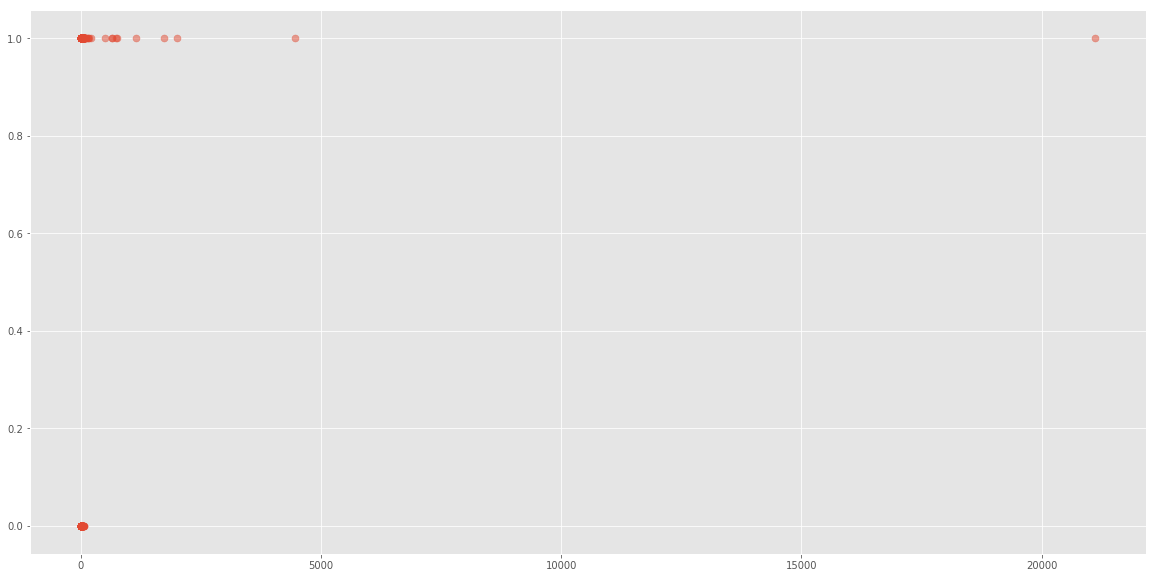

In [69]:
plt.scatter(dd['# of blights'], dd['BLIGHTED'],alpha=0.5,s=50)

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

#### Use 5-fold

In [71]:
seed = 2
kf = KFold(n_splits = 5, shuffle = True, random_state = seed)
result = next(kf.split(dd), None)

In [72]:
print (result)

(array([   0,    1,    2, ..., 7603, 7604, 7605]), array([   3,    4,   13, ..., 7593, 7595, 7596]))


#### Make training data and test data

In [73]:
train = dd.iloc[result[0]]
test =  dd.iloc[result[1]]

In [74]:
train.head()

,building_id,BLIGHTED,# of blights
0,dpt10mxffy3u,1,26.0
1,dpscpjv8g2f1,1,12.0
2,dpt10x0x6h5e,1,1.0
5,dpt10qxvfucg,1,2.0
6,dpt10rp1e98q,1,19.0


In [75]:
test.head()

,building_id,BLIGHTED,# of blights
3,dpt12rpzdy3c,1,0.0
4,dpsbebm3rhj8,1,0.0
13,dpsbyz49jz90,1,0.0
15,dpt10jsfvq3h,1,8.0
20,dpsbfz5ppczv,1,20.0


In [76]:
X_train= train['# of blights']
X_train = X_train.to_frame()

In [77]:
Y_train = train['BLIGHTED']
Y_train = Y_train.to_frame()

In [78]:
Y_train.__class__

pandas.core.frame.DataFrame

In [79]:
X_test= test['# of blights']
X_test = X_test.to_frame()
Y_test = test['BLIGHTED']
Y_test = Y_test.to_frame()

### Logistic Regression

In [80]:
clf = LogisticRegression()

In [81]:
clf.fit(X_train, Y_train)

/home/ksn/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [82]:
clf.score(X_train, Y_train)

0.8035831689677844

In [83]:
predict_y = clf.predict(X_train)
accuracy_score(Y_train, predict_y)

0.8035831689677844

#### Prediction

In [84]:
test.__class__

pandas.core.frame.DataFrame

In [85]:
test.head()

,building_id,BLIGHTED,# of blights
3,dpt12rpzdy3c,1,0.0
4,dpsbebm3rhj8,1,0.0
13,dpsbyz49jz90,1,0.0
15,dpt10jsfvq3h,1,8.0
20,dpsbfz5ppczv,1,20.0


In [86]:
test_new = test.drop(columns='building_id')

In [87]:
test_new = test_new.drop(columns='BLIGHTED')

In [88]:
test_new.head()

,# of blights
3,0.0
4,0.0
13,0.0
15,8.0
20,20.0


In [89]:
#pd.__version__

In [90]:
test_predict = clf.predict(test_new)
test_predict

array([0, 0, 0, ..., 0, 0, 0])

In [91]:
test['predicted'] = test_predict

/home/ksn/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [92]:
test.head(10)

,building_id,BLIGHTED,# of blights,predicted
3,dpt12rpzdy3c,1,0.0,0
4,dpsbebm3rhj8,1,0.0,0
13,dpsbyz49jz90,1,0.0,0
15,dpt10jsfvq3h,1,8.0,1
20,dpsbfz5ppczv,1,20.0,1
27,dpscp7b88w28,1,26.0,1
28,dpt127yqu4ye,1,0.0,0
32,dpscnwph3m8u,1,7.0,1
37,dpscmwzh012p,1,18.0,1
40,dpt108tttjpp,1,11.0,1


#### Prediction accuracy

In [93]:
print("Accuracy: %.4f" % (len(test[test['BLIGHTED'] == test['predicted']]) / len(test)))

Accuracy: 0.8101


### Boosting

In [94]:
import xgboost as xgb

In [95]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train,Y_train)
y_pred = xgb_model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.4f" % (accuracy))

Accuracy: 0.8784


### Random Forest

In [96]:
from sklearn.ensemble import RandomForestClassifier

In [97]:
clf = RandomForestClassifier()

In [98]:
clf.fit(X_train,Y_train)

/home/ksn/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [99]:
clf.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [100]:
#Y_test['BLIGHTED']

In [101]:
print("Accuracy: %.4f" % (sum(clf.predict(X_test) == Y_test['BLIGHTED']) / float(len(Y_test['BLIGHTED']))))

Accuracy: 0.8784


## Use data retrieved from `detroit-311.csv` as a feature

In [102]:
det311_data.head()

,ticket_id,city,issue_type,ticket_status,issue_description,rating,ticket_closed_date_time,acknowledged_at,ticket_created_date_time,ticket_last_updated_date_time,address,lat,lng,location,image,building_id
0,1516722,City of Detroit,Clogged Drain,Acknowledged,"Two drains one on each side of street, street ...",3,NaN,03/06/2015 10:03:38 PM,03/06/2015 09:57:52 PM,04/12/2015 01:01:10 AM,"13120-13130 Ilene Street Detroit, MI 48238, USA",42.384,-83.161,"(42.3839977668, -83.1610385642)",NaN,dpsc5eu08q20
1,1525361,City of Detroit,Clogged Drain,Acknowledged,standing water on lumplin,2,NaN,03/11/2015 04:23:11 PM,03/11/2015 04:14:29 PM,04/07/2015 02:04:44 PM,"1485 E. Outer Drive Detroit, Michigan",42.440,-83.081,"(42.4404708, -83.080919)",NaN,dpscmmyqbmkm
2,1525218,City of Detroit,Clogged Drain,Closed,CITZEN CALLED TO REPORT CLOGGED DRAINS,2,08/15/2015 12:03:43 AM,03/11/2015 03:39:05 PM,03/11/2015 03:26:20 PM,08/15/2015 12:03:44 AM,"15460 Eastburn Detroit, Michigan",42.445,-82.962,"(42.445244, -82.962038)",NaN,dpt12nuuj33p
3,1525214,City of Detroit,Clogged Drain,Acknowledged,Citizen called DWSD to report clogged drain,3,NaN,03/11/2015 03:35:02 PM,03/11/2015 03:22:42 PM,06/07/2015 10:07:48 PM,"17541 Mendota St Detroit, Michigan",42.421,-83.166,"(42.421043, -83.166194)",NaN,dpsc7d825xx9
4,1525142,City of Detroit,Clogged Drain,Acknowledged,@ THE CORNER OF GRIGGS & MARGARETA,2,NaN,03/11/2015 03:04:59 PM,03/11/2015 02:53:23 PM,03/11/2015 03:04:59 PM,"Griggs Detroit, Michigan",42.402,-83.163,"(42.4020334, -83.1628741)",NaN,dpsc5x4999sw


In [103]:
filtered_det311_data = det311_data[det311_data['building_id'].isin(labeled_data_sampled['building_id'])]

In [104]:
filtered_det311_data 

,ticket_id,city,issue_type,ticket_status,issue_description,rating,ticket_closed_date_time,acknowledged_at,ticket_created_date_time,ticket_last_updated_date_time,address,lat,lng,location,image,building_id
42,1542972,City of Detroit,Manhole Cover Issue,Acknowledged,Cover missing in the left through lane on Rosa...,2,NaN,03/20/2015 10:42:44 AM,03/20/2015 10:35:53 AM,04/01/2015 01:51:40 PM,"1931 Richton St Detroit, Michigan",42.389,-83.109,"(42.3888069, -83.1087773)",https://seeclickfix.com/files/issue_images/003...,dpschu9vgfq4
56,1549976,City of Detroit,Tree Issue,Acknowledged,The city @ the berm has caused the sidewalk to...,3,NaN,03/24/2015 10:12:20 AM,03/24/2015 09:27:36 AM,06/07/2015 10:08:29 PM,"11800 Longview Detroit, Michigan",42.404,-82.989,"(42.40381, -82.988985)",NaN,dpscpx3m0ns8
64,1551953,City of Detroit,Clogged Drain,Closed,"Customer claims sewer backup. Reporting, but a...",3,09/18/2015 12:11:09 AM,03/25/2015 11:35:28 AM,03/25/2015 11:23:12 AM,09/18/2015 12:11:09 AM,"8053 Prairie Detroit, Michigan",42.353,-83.143,"(42.352874, -83.1430929)",NaN,dpsbun1h5emv
89,1558765,City of Detroit,Clogged Drain,Acknowledged,NaN,3,NaN,03/28/2015 06:42:55 PM,03/28/2015 06:37:56 PM,03/28/2015 07:05:47 PM,"6024 Minock Street Detroit, MI 48228, USA",42.333,-83.231,"(42.3327827454, -83.2311706543)",NaN,dpsbf43p95hj
104,1563943,City of Detroit,Clogged Drain,Acknowledged,A CITIZEN CALLED TO REPORT THAT 3 DRAINS ARE C...,3,NaN,03/31/2015 11:42:20 AM,03/31/2015 11:36:23 AM,05/22/2015 12:14:54 PM,"19365 Shields Detroit, Michigan",42.437,-83.060,"(42.436723, -83.06019)",NaN,dpscmvmt3wpj
108,1563552,City of Detroit,Tree Issue,Acknowledged,CITIZEN STATES THAT THE TREE IS DEAD AND WOULD...,4,NaN,03/31/2015 10:48:07 AM,03/31/2015 09:18:14 AM,04/10/2015 12:56:46 PM,"2476 Kendall Detroit, Michigan",42.398,-83.123,"(42.3980729, -83.123458)",NaN,dpschqrdm8nc
111,1566576,City of Detroit,Water Main Break,Closed,Excessive water due to combination of water m...,3,08/24/2015 10:12:25 AM,04/01/2015 04:56:16 PM,04/01/2015 04:46:13 PM,08/24/2015 10:12:28 AM,"1071 Baldwin Detroit, Michigan",42.353,-83.000,"(42.352925, -83.000246)",NaN,dpsbzq1hpg6m
122,1565356,City of Detroit,Clogged Drain,Acknowledged,"Block alley drain, which causing the basement ...",2,NaN,04/01/2015 09:46:55 AM,04/01/2015 09:39:38 AM,04/01/2015 09:46:55 AM,"8134 Lauder Detroit, Michigan",42.353,-83.189,"(42.353003, -83.188908)",NaN,dpsbfyps5g3t
124,1565261,City of Detroit,Clogged Drain,Closed,A CITIZEN CALLED TO REPORT THAT THE 2 DRAINS O...,3,08/12/2015 12:07:21 AM,04/01/2015 09:16:52 AM,04/01/2015 09:07:31 AM,08/12/2015 12:07:21 AM,"15410 Mark Twain Detroit, Michigan",42.404,-83.186,"(42.403927, -83.186223)",NaN,dpsc5p3v1ww8
127,1569537,City of Detroit,Clogged Drain,Acknowledged,Clogged drain is on the west side of street h...,3,NaN,04/02/2015 04:44:53 PM,04/02/2015 04:36:20 PM,05/01/2015 09:27:58 AM,"15870 Alden St Detroit, Michigan",42.409,-83.130,"(42.4088719, -83.1304974)",NaN,dpsck26d6de6


In [105]:
num_of_det311 = filtered_det311_data['building_id'].value_counts()

In [106]:
#num_of_det311

In [107]:
num_of_det311_df = num_of_det311.to_frame()
num_of_det311_df = num_of_det311_df.reset_index()

num_of_det311_df.columns=['building_id','# of 311call']

dd2 = labeled_data_sampled.merge(num_of_det311_df, how='left')
dd2 = dd2.fillna(0)

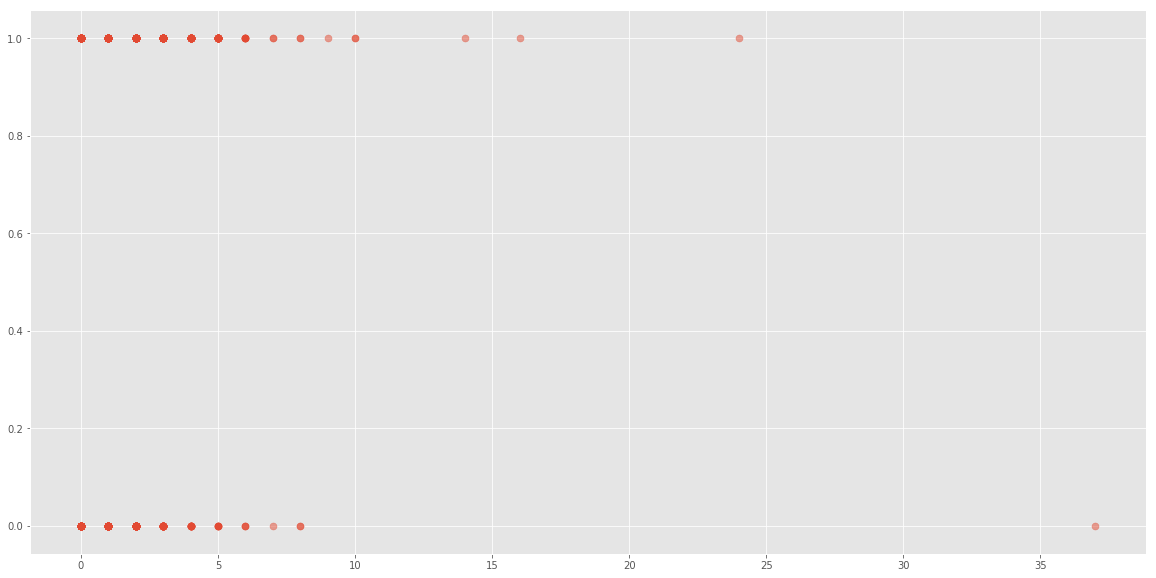

In [108]:
plt.scatter(dd2['# of 311call'], dd2['BLIGHTED'],alpha=0.5,s=50)

In [109]:
train = dd2.iloc[result[0]]
test =  dd2.iloc[result[1]]

In [110]:
X_train= train['# of 311call']
X_train = X_train.to_frame()
Y_train = train['BLIGHTED']
Y_train = Y_train.to_frame()

In [111]:
X_test= test['# of 311call']
X_test = X_test.to_frame()
Y_test = test['BLIGHTED']
Y_test = Y_test.to_frame()

In [112]:
clf = LogisticRegression()
clf.fit(X_train, Y_train)
clf.score(X_train, Y_train)

/home/ksn/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6377383300460223

In [113]:
test_new = test.drop(columns='building_id')
test_new = test_new.drop(columns='BLIGHTED')
test_predict = clf.predict(test_new)
test['predicted'] = test_predict
len(test[test['BLIGHTED'] == test['predicted']]) / len(test)

/home/ksn/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


0.6235216819973719

### Boosting

In [114]:
xgb_model = xgb.XGBRegressor()

In [115]:
xgb_model.fit(X_train,Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [116]:
print(xgb_model)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [117]:
#xgb_model.score(X_train, Y_train)

In [118]:
y_pred = xgb_model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [119]:
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.4f" % (accuracy))

Accuracy: 0.6235


In [120]:
#filtered_det311_data

In [121]:
#filtered_det311_data['issue_type'].value_counts()

### Random Forest

In [122]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train,Y_train)
clf.predict(X_test)
print("Accuracy: %.4f" % (sum(clf.predict(X_test) == Y_test['BLIGHTED']) / float(len(Y_test['BLIGHTED']))))

Accuracy: 0.6235


/home/ksn/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


## Use data retrieve from `detroit-crime.csv` as a feature

In [123]:
crime_data

,ROWNUM,CASEID,INCINO,CATEGORY,OFFENSEDESCRIPTION,STATEOFFENSEFILECLASS,INCIDENTDATE,HOUR,SCA,PRECINCT,COUNCIL,NEIGHBORHOOD,CENSUSTRACT,ADDRESS,LON,LAT,LOCATION,building_id
0,53256,1953933,1506030028.1,ASSAULT,ASSAULT AND BATTERY/SIMPLE ASSAULT,13001.0,06/03/2015 12:00:00 AM,2,1007.0,10.0,City Council District 5,PETOSKEY-OTSEGO,5334.0,09100 PETOSKEY,-83.1221,42.3678,"PETOSKEY\n09100\n(42.3676, -83.1219)",dpsch8b66dmg
1,17631,1917717,1503010158.1,LARCENY,LARCENY - PARTS AND ACCESSORIES FROM VEHICLE,23006.0,03/01/2015 12:00:00 AM,9,608.0,6.0,City Council District 7,GRANDALE,5452.0,00 PLYMOUTH AND MANSFIELD,-83.2035,42.3724,"00 PLYMOUTH AND MANSFIELD\n(42.3725, -83.2033)",dpsc49tj1gve
2,11207,1910955,1502080223.1,STOLEN VEHICLE,VEHICLE THEFT,24001.0,02/08/2015 12:00:00 AM,18,1105.0,11.0,City Council District 3,OUTER DRIVE VAN DYKE,5051.0,00 E 7 MILE VAN DYKE,-83.0241,42.4338,"00 E 7 MILE VAN DYKE\n(42.4339, -83.0241)",dpscqszdy38h
3,116589,2018186,1511090188.1,WEAPONS OFFENSES,WEAPONS OFFENSE (OTHER),52003.0,11/09/2015 12:00:00 AM,12,210.0,2.0,City Council District 6,TIREMAN,NaN,06600 BARTON,-83.1381,42.3496,"BARTON\n06600\n(42.3494, -83.1379)",dpsbujs8mcek
4,85790,1986862,1508239803.1,LARCENY,LARCENY - PARTS AND ACCESSORIES FROM VEHICLE,23006.0,08/14/2015 12:00:00 AM,7,309.0,3.0,City Council District 6,WEST CANFIELD,5204.0,00900 W WILLIS,-83.0692,42.3481,"W WILLIS\n00900\n(42.3481, -83.0693)",dpsbvtnze650
5,27456,1927752,1503280235.1,TRAFFIC VIOLATIONS-MOTORCYCLE VIOLATIONS,MISCELLANEOUS - GENERAL ASSISTANCE,99008.0,03/28/2015 12:00:00 AM,17,906.0,9.0,City Council District 4,BURBANK,5006.0,15000 GLENWOOD,-82.9660,42.4307,"GLENWOOD\n15000\n(42.4305, -82.9658)",dpt12h608pf8
6,1219,1900139,1501050342.1,BURGLARY,BURGLARY - BURGLARY - FORCED ENTRY - RESIDENCE,22001.0,01/01/2015 12:00:00 AM,4,607.0,6.0,City Council District 7,FRANKLIN PARK,5468.0,09500 BRACE APT 207,-83.2239,42.3655,"BRACE APT 207\n09500\n(42.3654, -83.2236)",dpsc40qhytd7
7,111380,2012912,1510270083.1,LARCENY,LARCENY - PERSONAL PROPERTY FROM VEHICLE,23005.0,10/26/2015 12:00:00 AM,22,709.0,7.0,City Council District 5,ELMWOOD PARK,NaN,01900 CHENE COURT,-83.0285,42.3451,"CHENE COURT\n01900\n(42.3454, -83.0283)",dpsbyssqpdz0
8,25551,1925814,1503238007.1,AGGRAVATED ASSAULT,AGG/FEL ASSAULT - FAMILY - OTHER WEAPON,13002.0,03/22/2015 12:00:00 AM,2,707.0,7.0,City Council District 5,MCDOUGALL-HUNT,5168.0,03600 PULFORD ST.,-83.0229,42.3617,"03600 PULFORD ST\n(42.3617, -83.0229)",dpsbyz8wf1nz
9,73985,1974951,1507250221.1,DAMAGE TO PROPERTY,DAMAGE TO PROPERTY - PRIVATE PROPERTY,29000.0,07/25/2015 12:00:00 AM,14,201.0,2.0,City Council District 1,CERVENY,5376.0,16800 FREELAND,-83.1864,42.4159,"FREELAND\n16800\n(42.4158, -83.1861)",dpsc719d82u7


In [124]:
crime_data['CATEGORY'].value_counts()

TRAFFIC VIOLATIONS-MOTORCYCLE VIOLATIONS       28252
ASSAULT                                        15905
LARCENY                                        13573
DAMAGE TO PROPERTY                              9078
AGGRAVATED ASSAULT                              7974
BURGLARY                                        7478
STOLEN VEHICLE                                  6682
TRAFFIC VIOLATIONS-DRIVING ON SUSPENDED         5554
FRAUD                                           4703
ROBBERY                                         3048
DANGEROUS DRUGS                                 2991
OBSTRUCTING JUDICIARY                           1356
WEAPONS OFFENSES                                1196
ESCAPE                                           875
SOLICITATION                                     828
BRIBERY                                          809
ARSON                                            752
OUIL DISPOSE OF VEHICLE TO AVOID FORFEITURE      733
RUNAWAY                                       

### Retrieve from `detroit-crime.csv`

In [125]:
crime_data['building_id'].value_counts()

dpscq6cz3hnp    26
dpscq71b91w0    25
dpscq6cxks0z    24
dpscq6cxyyg7    22
dpsc41kpzsj4    21
dpscq718wce2    21
dpscq6cxqu5r    20
dpsc41s0rwtp    19
dpsbvg8kk38f    19
dpscq6cwyce6    18
dpsc41kruk44    18
dpscq718s98b    18
dpsc41s31cre    18
dpsc41krcupd    18
dpscq6czcny5    17
dpscj2g9nv4d    17
dpsbvg87ns73    17
dpsbvg8kq9e6    17
dpscq6cz7s0x    16
dpsby6g0vmqv    16
dpsc41s1p9m5    16
dpscq6cxuwbg    16
dpscq579g5gb    15
dpsbvg87wwgm    15
dpsc41s39up8    15
dpscj2g9srxy    15
dpsbvg87hk2c    15
dpscq579715u    15
dpscj2g9hmpf    14
dpscq719nu5k    14
                ..
dpsc6n8189bm     1
dpsc3mv5rmd6     1
dpscj93br1xp     1
dpscngxybykf     1
dpsck11gfyz3     1
dpscmknq6tny     1
dpsck22bt48m     1
dpsc4fbujkvd     1
dpsbgx6d99u8     1
dpscjmx8h9jj     1
dpsc5svc6d0j     1
dpsbfj5wzr75     1
dpt0bpyt4yk1     1
dpsbv0mmnqjc     1
dpsc7dnu50h4     1
dpsc4hxg3zfb     1
dpsc52mx70nm     1
dpsc69p6nyfk     1
dpsbvbfzjzft     1
dpsbvcuhmkn2     1
dpsc14f586pm     1
dpt10x0xkkn5

In [126]:
filtered_crime_data = crime_data[crime_data['building_id'].isin(labeled_data_sampled['building_id'])]

In [127]:
num_of_crimes = filtered_crime_data['building_id'].value_counts()
#filtered_crime_data

In [128]:
num_of_crimes_df = num_of_crimes.to_frame()

In [129]:
num_of_crimes_df.head()

,building_id
dpsc74hjnt77,8
dpscj2y11mhd,8
dpscktgdgdcm,8
dpsbvwyjwreu,6
dpsbvptrk5g7,6


In [130]:
num_of_crimes_df = num_of_crimes_df.reset_index()
num_of_crimes_df.columns = ['building_id','# of crimes']
dd_crime  = labeled_data_sampled.merge(num_of_crimes_df, how='left')
dd_crime = dd_crime.fillna(0)

In [131]:
dd_crime

,building_id,BLIGHTED,# of crimes
0,dpt10mxffy3u,1,0.0
1,dpscpjv8g2f1,1,0.0
2,dpt10x0x6h5e,1,0.0
3,dpt12rpzdy3c,1,0.0
4,dpsbebm3rhj8,1,0.0
5,dpt10qxvfucg,1,0.0
6,dpt10rp1e98q,1,0.0
7,dpt10b8tdmjz,1,0.0
8,dpt10nzgdrrc,1,0.0
9,dpsb7v8ru41z,1,0.0


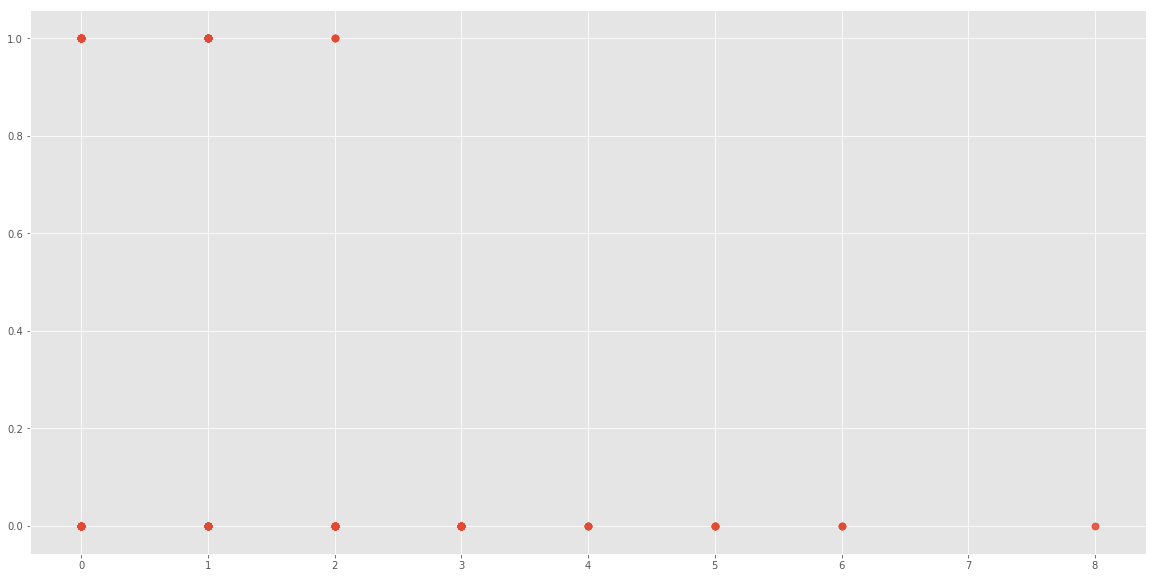

In [132]:
rcParams['figure.figsize'] = 20,10
plt.scatter(dd_crime['# of crimes'], dd_crime['BLIGHTED'],alpha=0.5,s=50)

#### Logistic Regression

In [133]:
result = next(kf.split(dd_crime), None)
train = dd_crime.iloc[result[0]]
test =  dd_crime.iloc[result[1]]
X_train= train['# of crimes']
X_train = X_train.to_frame()
Y_train = train['BLIGHTED']
Y_train = Y_train.to_frame()
X_test= test['# of crimes']
X_test = X_test.to_frame()
Y_test = test['BLIGHTED']
Y_test = Y_test.to_frame()
clf = LogisticRegression()
clf.fit(X_train, Y_train)
clf.score(X_train, Y_train)
predict_y = clf.predict(X_train)
accuracy_score(Y_train, predict_y)

/home/ksn/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8928336620644313

### Boosting

In [134]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train,Y_train)
y_pred = xgb_model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.4f" % (accuracy))

Accuracy: 0.9093


### Randome Forest

In [135]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train,Y_train)
clf.predict(X_test)
print("Accuracy: %.4f" % (sum(clf.predict(X_test) == Y_test['BLIGHTED']) / float(len(Y_test['BLIGHTED']))))

Accuracy: 0.9093


/home/ksn/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


## Multi dimensional inputs 2 class classification

In [136]:
#(dd2['BLIGHTED'] == dd_crime['BLIGHTED']).unique()

In [137]:
#dd2['# of 311call']

In [138]:
df_complete = pd.concat([dd['building_id'],dd['# of blights'], dd2['# of 311call'],dd_crime['# of crimes'],dd_crime['BLIGHTED']], axis=1)

In [139]:
train = df_complete.iloc[result[0]]
test =  df_complete.iloc[result[1]]

In [140]:
X_train= train[['# of blights','# of 311call','# of crimes']]

In [141]:
Y_train = train['BLIGHTED']

In [142]:
X_test= test[['# of blights','# of 311call','# of crimes']]
Y_test = test['BLIGHTED']

### Logistic Regression

In [143]:
clf = LogisticRegression()
clf.fit(X_train, Y_train)
clf.score(X_train, Y_train)
predict_y = clf.predict(X_train)
accuracy_score(Y_train, predict_y)

0.8933267587113741

### Boosting

In [144]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train,Y_train)
y_pred = xgb_model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.4f" % (accuracy))

Accuracy: 0.9146


In [145]:
round(y_pred[1])

1.0

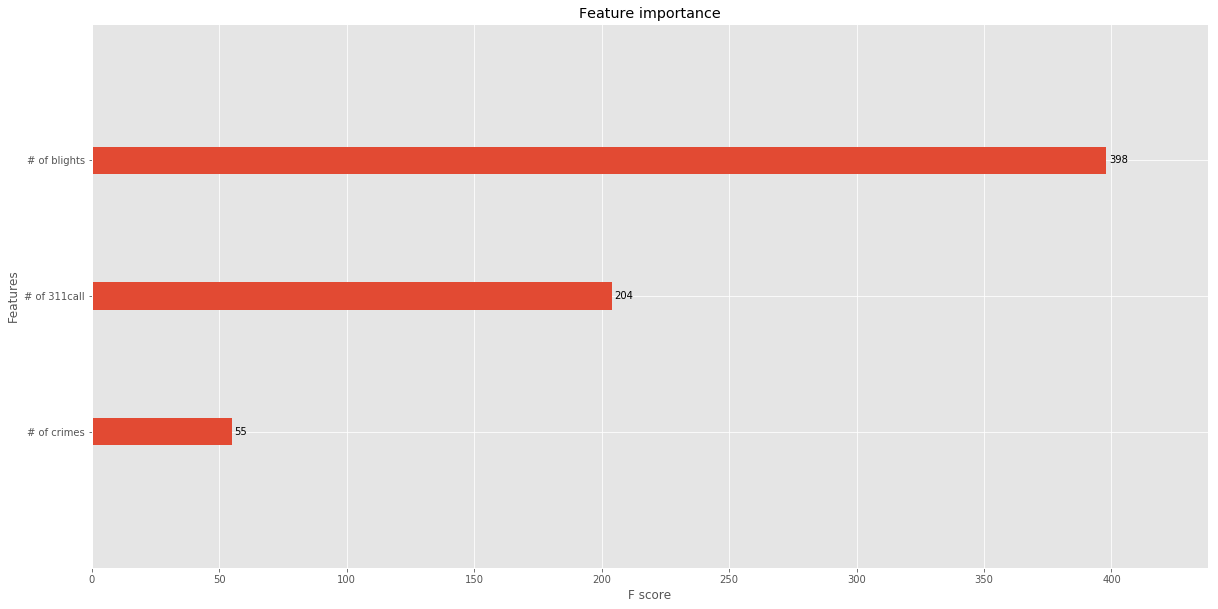

In [146]:
xgb_plot = xgb.plot_importance(xgb_model)
xgb_plot

### Random Forest

In [147]:
#Y_test

In [148]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train,Y_train)
clf.predict(X_test)
print("Accuracy: %.4f" % (sum(clf.predict(X_test) == Y_test) / float(len(Y_test))))

Accuracy: 0.9093
